In [2]:
import nrrd # use: pip install pynrrd
import zarr
import numpy as np
import tifffile
from matplotlib import pyplot as plt
import os
import cv2 #pip install opencv-python
import json
import skimage
from skimage.segmentation import mark_boundaries, slic
from skimage.morphology import *
from pysnic.algorithms.snic import snic #pip install pysnic
from voxel_utils import *
from ipywidgets import interact, IntSlider

zarr1_path = "/Users/jamesdarby/Documents/VesuviusScroll/GP/Vesuvius_Data_Download/Scroll1/Scroll1.zarr"
zarr4_path = "/Volumes/16TB_slow_RAID_0/Scroll4/Scroll4.zarr"
Scroll1_multi_res_zarr = zarr.open(zarr1_path, mode='r')
Scroll4_multi_res_zarr = zarr.open(zarr4_path, mode='r')
print(Scroll1_multi_res_zarr.info)

Name        : /
Type        : zarr.hierarchy.Group
Read-only   : True
Store type  : zarr.storage.DirectoryStore
No. members : 6
No. arrays  : 6
No. groups  : 0
Arrays      : 0, 1, 2, 3, 4, 5



In [3]:
z1 = Scroll1_multi_res_zarr[0]
z2 = Scroll1_multi_res_zarr[1]

s4z1 = Scroll4_multi_res_zarr[0]
s4z2 = Scroll4_multi_res_zarr[1]
s4z3 = Scroll4_multi_res_zarr[2]
s4z4 = Scroll4_multi_res_zarr[3]
s4z5 = Scroll4_multi_res_zarr[4]

print(z1.info, z2.info)
print(s4z1.info, s4z2.info)

Name               : /0
Type               : zarr.core.Array
Data type          : uint16
Shape              : (14376, 7888, 8096)
Chunk shape        : (128, 128, 128)
Order              : C
Read-only          : True
Compressor         : None
Store type         : zarr.storage.DirectoryStore
No. bytes          : 1836138602496 (1.7T)
No. bytes stored   : 22817 (22.3K)
Storage ratio      : 80472393.5
Chunks initialized : 112/448384
 Name               : /1
Type               : zarr.core.Array
Data type          : uint16
Shape              : (7188, 3944, 4048)
Chunk shape        : (128, 128, 128)
Order              : C
Read-only          : True
Compressor         : None
Store type         : zarr.storage.DirectoryStore
No. bytes          : 229517325312 (213.8G)
No. bytes stored   : 14624 (14.3K)
Storage ratio      : 15694565.5
Chunks initialized : 56/56544

Name               : /0
Type               : zarr.core.Array
Data type          : uint16
Shape              : (26391, 7960, 8120)
Chunk 

In [4]:
#helper functions: TODO move to separate file
import numpy as np
from skimage.color import gray2rgb, label2rgb
from skimage.segmentation import find_boundaries
from skimage.util import img_as_float
from skimage.morphology import dilation, square
import random

def mark_boundaries_color(image, label_img, color=None, outline_color=None, mode='outer', background_label=0, dilation_size=1):
    """Return image with boundaries between labeled regions highlighted with consistent colors derived from labels.

    Parameters:
    - image: Input image.
    - label_img: Image with labeled regions.
    - color: Ignored in this version.
    - outline_color: If specified, use this color for the outline. Otherwise, use the same as boundary.
    - mode: Choose 'inner', 'outer', or 'thick' to define boundary type.
    - background_label: Label to be treated as the background.
    - dilation_size: Size of the dilation square for the boundaries.

    Returns:
    - Image with boundaries highlighted.
    """
    # Ensure input image is in float and has three channels
    float_dtype = np.float32  # Use float32 for efficiency
    marked = img_as_float(image, force_copy=True).astype(float_dtype, copy=False)
    if marked.ndim == 2:
        marked = gray2rgb(marked)

    # Create a color map normalized by the number of unique labels
    unique_labels = np.unique(label_img)
    color_map = plt.get_cmap('nipy_spectral')  # You can change 'nipy_spectral' to any other colormap

    # Find boundaries and apply colors
    boundaries = find_boundaries(label_img, mode=mode, background=background_label)
    for label in unique_labels:
        if label == background_label:
            continue
        # Normalize label value to the range of the colormap
        normalized_color = color_map(label / np.max(unique_labels))[:3]  # Get RGB values only
        label_boundaries = find_boundaries(label_img == label, mode=mode)
        label_boundaries = dilation(label_boundaries, square(dilation_size))
        marked[label_boundaries] = normalized_color
        if outline_color is not None:
            outlines = dilation(label_boundaries, square(dilation_size + 1))
            marked[outlines] = outline_color
        else:
            marked[label_boundaries] = normalized_color

    return marked


def consistent_color(label):
    """Generate a consistent color for a given label using a hash function."""
    random.seed(hash(label))
    return [random.random() for _ in range(3)]

def mark_boundaries_multicolor(image, label_img, color=None, outline_color=None, mode='outer', background_label=0, dilation_size=1):
    """Return image with boundaries between labeled regions highlighted with consistent colors.

    Parameters are the same as in the original function but color is ignored if provided.
    """
    # Ensure input image is in float and has three channels
    float_dtype = np.float32  # Use float32 for efficiency
    marked = img_as_float(image, force_copy=True).astype(float_dtype, copy=False)
    if marked.ndim == 2:
        marked = gray2rgb(marked)

    # Generate consistent colors for each unique label in label_img
    unique_labels = np.unique(label_img)
    color_map = {label: consistent_color(label) for label in unique_labels if label != background_label}

    # Find boundaries and apply colors
    boundaries = find_boundaries(label_img, mode=mode, background=background_label)
    for label, color in color_map.items():
        label_boundaries = find_boundaries(label_img == label, mode=mode)
        label_boundaries = dilation(label_boundaries, square(dilation_size))
        if outline_color is not None:
            outlines = dilation(label_boundaries, square(dilation_size))
            marked[outlines] = outline_color
        marked[label_boundaries] = color

    return marked

def plot_segmentation_results(test_slice, segmentation):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Show marked boundary image
    axes[0].imshow(mark_boundaries(test_slice, np.array(segmentation)))
    axes[0].set_title("Marked Boundary")

    # Show unmarked boundary image
    axes[1].imshow(test_slice, cmap='gray')
    axes[1].set_title("Unmarked Boundary")

    plt.show()

(356, 356, 356)


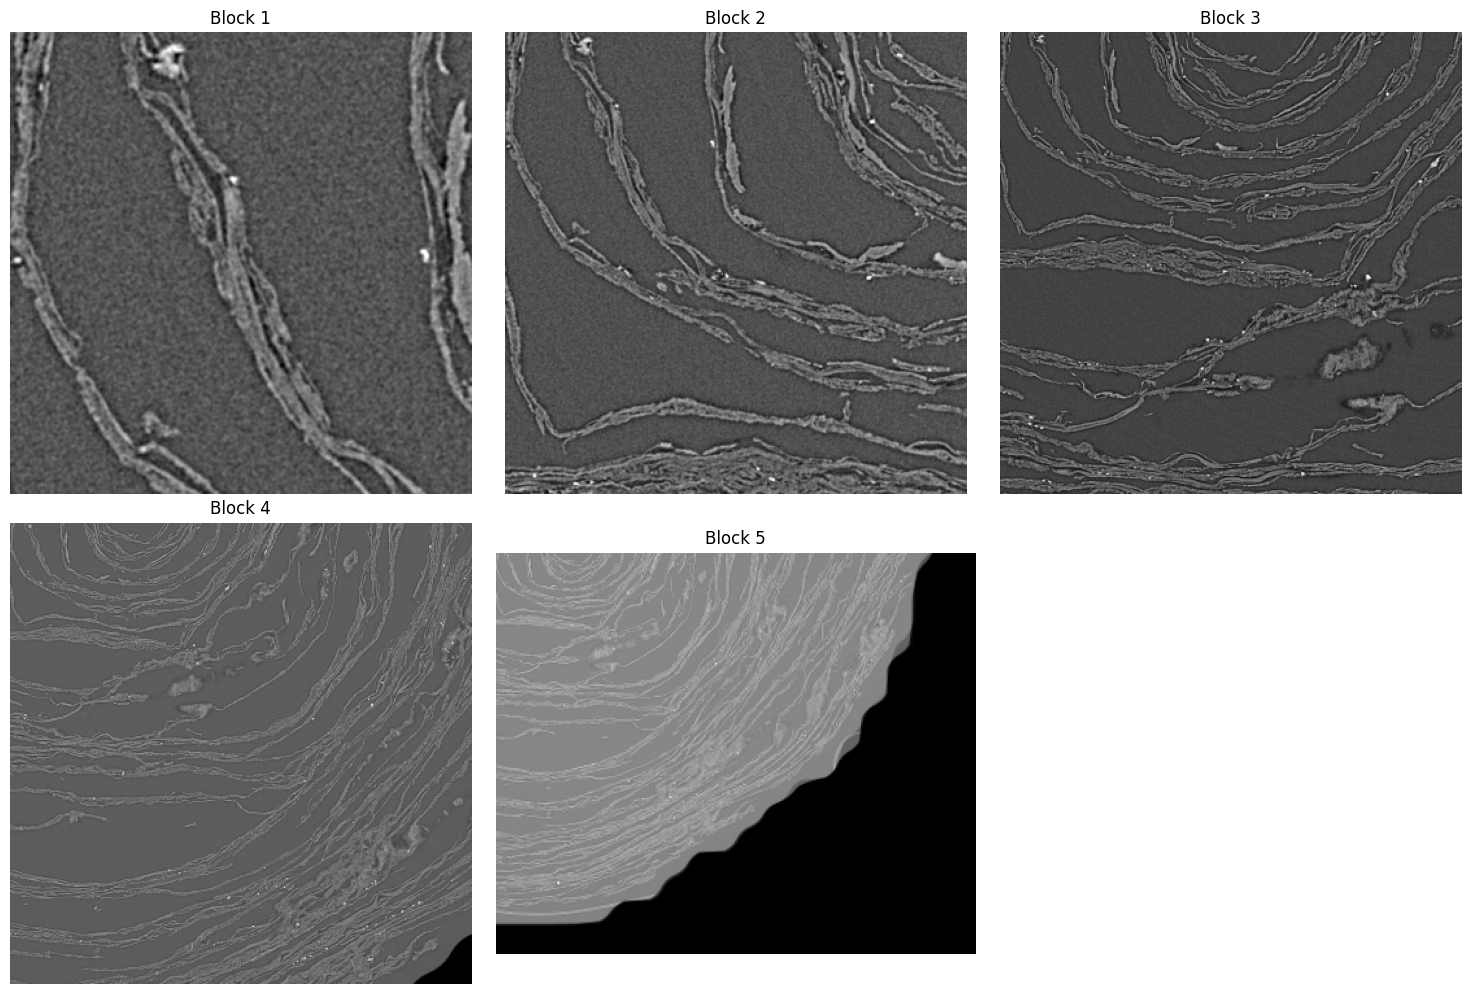

In [5]:
#create multi_resolution test blocks and display the first slice of each
# Define the block size and the starting coordinates
block_size = 356 
# x=3500
# y=4200
# x=2775
# y=4500
# # x=3070 
# # y=4757
# # z = 6515
# z=7900

x=3250
y=3900
z=8350

xe = x + block_size
ye = y + block_size
ze = z + block_size

scroll_num = 4

#TODO: cleanup
# Replace 'z' with the correct array variable that contains the data
test_block_1 = s4z1[z:ze, y:ye, x:xe] #matches khartes coordinates
test_block_2 = s4z2[int(z/2):int(z/2)+block_size, int(y/2):int(y/2)+block_size, int(x/2):int(x/2)+block_size] #matches khartes coordinates
test_block_3 = s4z3[int(z/4):int(z/4)+block_size, int(y/4):int(y/4)+block_size, int(x/4):int(x/4)+block_size] #matches khartes coordinates
scale_factor = 8
test_block_4 = s4z4[int(z/scale_factor):int(z/scale_factor)+block_size, int(y/scale_factor):int(y/scale_factor)+block_size, int(x/scale_factor):int(x/scale_factor)+block_size] #matches khartes coordinates
scale_factor = 16
test_block_5 = s4z5[int(z/scale_factor):int(z/scale_factor)+block_size, int(y/scale_factor):int(y/scale_factor)+block_size, int(x/scale_factor):int(x/scale_factor)+block_size] #matches khartes coordinates

print(test_block_1.shape)
# Initialize the figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))  # Adjust figsize to fit your screen or preferences

# Plot the first slice of each block
axes[0, 0].imshow(test_block_1[0], cmap='gray')
axes[0, 0].set_title('Block 1')
axes[0, 0].axis('off')  # Turn off axis labels

axes[0, 1].imshow(test_block_2[0], cmap='gray')
axes[0, 1].set_title('Block 2')
axes[0, 1].axis('off')

axes[0, 2].imshow(test_block_3[0], cmap='gray')
axes[0, 2].set_title('Block 3')
axes[0, 2].axis('off')

axes[1, 0].imshow(test_block_4[0], cmap='gray')
axes[1, 0].set_title('Block 4')
axes[1, 0].axis('off')

axes[1, 1].imshow(test_block_5[0], cmap='gray')
axes[1, 1].set_title('Block 5')
axes[1, 1].axis('off')

# Assuming there's a sixth test block to fill the last subplot, or you can leave it blank or use any other image
# For this example, let's assume it's blank
axes[1, 2].set_visible(False)  # Hide the last subplot if not needed

plt.tight_layout()  # Adjust subplots to fit into the figure area.
plt.show()

In [6]:
from scipy.ndimage import gaussian_filter

scale_factor = 2
test_block = test_block_2

smoothed_block = gaussian_filter(test_block, sigma=2)

#consider otsu thresholding, this may break in denser regions
threshold_mask = smoothed_block > np.mean(smoothed_block)
obj_size = 20000
threshold_mask = remove_small_holes(remove_small_objects(threshold_mask, obj_size), obj_size)
mask_ratio = np.sum(threshold_mask) / threshold_mask.size
print(threshold_mask.shape, np.mean(smoothed_block), mask_ratio)

(356, 356, 356) 22340.322733162735 0.24774546824044746


In [7]:
# slider display result of threshold mask
# Assuming 'res' is your 3D array with int64 data type
def plot_slice(slice_index, axis=0):
    plt.figure(figsize=(8, 6))
    if axis == 1:
        plt.imshow(test_block[:,slice_index,:] * threshold_mask [:,slice_index,:], cmap='gray')
    elif axis == 2:
        plt.imshow(test_block[:,:,slice_index] * threshold_mask [:,:,slice_index], cmap='gray')
    else:
        plt.imshow(test_block[slice_index,:,:] * threshold_mask [slice_index,:,:], cmap='gray')
    plt.colorbar()
    plt.title(f'Slice {slice_index}')
    plt.show()

# Create a slider to browse through slices
interact(plot_slice, slice_index=IntSlider(min=0, max=threshold_mask .shape[0]-1, step=1, value=0), axis=IntSlider(min=0, max=2, step=1, value=0))


interactive(children=(IntSlider(value=0, description='slice_index', max=355), IntSlider(value=0, description='…

<function __main__.plot_slice(slice_index, axis=0)>

### slic function notes
slic runtime scale linearily with n_segments, max_num_iters
scales cubicly /linearlly per voxel with test_block size
compactness is a trade off between color consistency per superpixel
and spatial similarity of each superpixel, seems to have less of an effect 
when using a mask than when not using a mask; ideal value also varies considerably
need to explore its value logarithmically (0.01, 0.1, 1, 10, 100, 1000, 10000 etc) to see big changes, 
then can finetune later once reasonable behaviour is found. Less masked off area also results in higher runtime if using a mask.

running slic on lower resolution parts of the scroll gets better coverage of the scroll for the runtime, thus find the lowest accepatable resolution to autosegment.

Preferred over snic (though it looks like that is a better base algorithm) as it has more parameters to control, has a scipy implementation that works well in 3d, can easily use a mask which drastically improves performance and has comparable runtime when parameters are tuned.

More segments with higher compactness is more likly to seperate sheets when they merge together due to smaller superpixel sizes and higher 'grid' prior but more segments scales runtime up by ~O(nlogn) from experimental results.

In [8]:
#depending on input (test_block size, amount masked) & parameters(n_segments, max_num_iters), can take awhile -> computationally expensive

n_segments=int(30000*mask_ratio) #keep n_segments proportional to mask ratio so approx number of superpixels per surface area is more similar across sparser/denser regions
res_s = slic(test_block, n_segments=n_segments, compactness=50000, mask=threshold_mask, max_num_iter=1, enforce_connectivity=True, spacing=None, channel_axis=None)
print(n_segments)

7432


In [9]:
#just because I kept restarting the above cell by habit and didnt want to recompute the slic
#will remove later
res=res_s

In [10]:
# slider display result of SLIC superpixel operation on top of raw data
#TODO: make this a proper function instead of copying it around and editting
#But each version needs to work just a bit differently, so maybe not

# very useful pattern to quickly visualise results though and overlay stuff
def plot_slice(slice_index, axis=0):
    plt.figure(figsize=(8, 6))
    if axis == 1:
        plt.imshow(mark_boundaries_multicolor(test_block[:,slice_index,:], res[:,slice_index,:]))
    elif axis == 2:
        plt.imshow(mark_boundaries_multicolor(test_block[:,:,slice_index], res[:,:,slice_index]))
    else:
        plt.imshow(mark_boundaries_multicolor(test_block[slice_index,:,:], res[slice_index,:,:]))
    plt.colorbar()
    plt.title(f'Slice {slice_index}')
    plt.show()

# Create a slider to browse through slices
interact(plot_slice, slice_index=IntSlider(min=0, max=res.shape[0]-1, step=1, value=0), axis=IntSlider(min=0, max=2, step=1, value=0))


interactive(children=(IntSlider(value=0, description='slice_index', max=355), IntSlider(value=0, description='…

<function __main__.plot_slice(slice_index, axis=0)>

### failed experiments

In [11]:
# from skimage import measure, filters, morphology
# from skimage.segmentation import watershed
# from scipy import ndimage as ndi


# # Create a distance map if needed (can skip if you use the array as is for markers)
# distance = ndi.distance_transform_edt(res > 0)  # Operate on non-background

# # Generate markers from the existing superpixel data (ensuring they are labeled)
# markers = measure.label(res)
# print(markers.shape)

# # Apply watershed
# labels = watershed(-distance, markers=None, mask=(res > 0), connectivity=100)


In [12]:
# print(labels.shape, len(np.unique(labels)))
# # print(labels)

In [13]:
# #labels for finding naive connected components, too many connections!
# from scipy.ndimage import label
# labelled_array, num_features = label(res)
# print(num_features)

In [14]:
# distance = ndi.distance_transform_edt(labelled_array > 0)  # Operate on non-background

# # Generate markers from the existing superpixel data (ensuring they are labeled)
# markers = measure.label(labelled_array)
# print(markers.shape)

# # Apply watershed
# labels = watershed(-distance, markers=None, mask=(labelled_array > 0), connectivity=0)
# print(labels.shape, len(np.unique(labels)))

In [15]:
# from scipy.ndimage import gaussian_filter
# target_number_of_segments = int(test_block.shape[1] * 4)
# compactness = 7000000#15000000.0
# number_of_pixels = test_block.shape[0] * test_block.shape[1]
# block_slice = int(block_size/2)

# ts = test_block[block_slice,:,:]
# ts = gaussian_filter(ts, sigma=2)
# test_slice = np.expand_dims(ts, axis=-1).tolist()
# segmentation, _, centroids = snic(
#     test_slice, target_number_of_segments, compactness)
# actual_number_of_segments = len(np.unique(segmentation))
# print(f"Actual number of segments: {actual_number_of_segments}")
# print(np.array(segmentation).shape, np.array(segmentation).max())
# plot_segmentation_results(ts, segmentation)

### end of failed experiments

In [16]:
#load obj files and convert them into slice intersections then face voxel lists
s4_obj_list = ["/Volumes/16TB_RAID_0/Scroll4/segments/20231122192640/20231122192640.obj",
            "/Volumes/16TB_RAID_0/Scroll4/segments/20231111135340/20231111135340.obj"]
vertex_dicts, connected_vertices_graphs = build_vertex_dicts(s4_obj_list, roi_x=[x, x+scale_factor*block_size], roi_y=[y, y+scale_factor*block_size], roi_z=[z, z+scale_factor*block_size])
print(len(vertex_dicts), len(connected_vertices_graphs))
face_voxels_lists_t = build_face_voxels_lists(s4_obj_list, vertex_dicts, connected_vertices_graphs)

2 2
Number of connected components: 0
component faces: 0
Number of connected components: 6
component faces: 6
length of connected faces in roi: 2
number of face voxels: 7588194
number of face voxels: 672245
number of face voxels: 8929804
number of face voxels: 13672740
number of face voxels: 6379229
number of face voxels: 6190208


In [17]:
#just to stop myself accidentally redoing that long computation
face_voxels_lists = face_voxels_lists_t

In [18]:
from skimage import morphology

print(len(face_voxels_lists[0]))
# obj_intersection = np.zeros((block_size*scale_factor, block_size*scale_factor, block_size*scale_factor))
obj_intersection = np.zeros((block_size, block_size, block_size))
# t_obj_intersection = np.zeros((block_size, block_size, block_size))

#assign each voxel intersection to an object with a unique id
#represented as a 3d array
for i in range(len(face_voxels_lists)):
    print(i, len(face_voxels_lists[i]))
    # temp_obj_intersection = np.zeros((block_size, block_size, block_size))
    for v in face_voxels_lists[i]:
        # temp_obj_intersection[(v[2]-1)//scale_factor, (v[1]-1)//scale_factor, (v[0]-1)//scale_factor] = 1
        obj_intersection[(v[2]-1)//scale_factor, (v[1]-1)//scale_factor, (v[0]-1)//scale_factor] = i+1
    # temp_obj_intersection = morphology.binary_erosion(temp_obj_intersection, morphology.ball(2))
    # temp_obj_intersection = morphology.skeletonize(temp_obj_intersection) #doesnt work downstream for some reason, erode instead
    # temp_obj_intersection = temp_obj_intersection * (i+1)
    # t_obj_intersection = t_obj_intersection + temp_obj_intersection
    
print(obj_intersection.shape, len(np.unique(obj_intersection)))

7588194
0 7588194
1 672245
2 8929804
3 13672740
4 6379229
5 6190208
(356, 356, 356) 7


In [19]:
#Hacky skeletonize obj intersection
# from skimage.morphology import skeletonize
# obj_intersection = skeletonize(obj_intersection)

In [20]:
#Hacky erode obj intersection
# from skimage import morphology
# selem = morphology.ball(3)
# obj_intersection = morphology.binary_erosion(obj_intersection, selem)

In [21]:
# #display as slider: temp obj intersection mask (skeletonized or eroded)
# def plot_slice(slice_index, axis=0):
#     plt.figure(figsize=(8, 6))
#     if axis == 1:
#         plt.imshow(test_block[:,slice_index,:]*t_obj_intersection[:,slice_index,:], cmap='gray')
#     elif axis == 2:
#         plt.imshow(test_block[:,:,slice_index]*t_obj_intersection[:,:,slice_index], cmap='gray')
#     else:
#         plt.imshow(test_block[slice_index,:,:]*t_obj_intersection[slice_index,:,:], cmap='gray')
#     plt.colorbar()
#     plt.title(f'Slice {slice_index}')
#     plt.show()

# # Create a slider to browse through slices
# interact(plot_slice, slice_index=IntSlider(min=0, max=obj_intersection.shape[0]-1, step=1, value=0), axis=IntSlider(min=0, max=2, step=1, value=0))

In [22]:
#Hacky shift the obj intersection away from umbilicus naivly -> obj follows surface, we want to shift to center
#TODO: store umbilicus location in zarr metadata! and use that to shift
#Ideally only shift close segments apart a bit, not all segments, this just makes a dumb tradeoff
# shift_x = -5 #shift in x direction, - for left, + for right
# shift_y = 5 #shift in y direction, - for up, + for down

# #axis 0 is z, axis 1 is y, axis 2 is x
# obj_intersection = np.roll(obj_intersection, shift_x, axis=2)
# obj_intersection = np.roll(obj_intersection, shift_y, axis=1)

# if shift_x < 0:
#     # Blank out the last -shift_x columns
#     obj_intersection[:, :, shift_x:] = 0
# else:
#     # Blank out the first shift_x columns
#     obj_intersection[:, :, :shift_x] = 0

# if shift_y < 0:
#     # Blank out the last -shift_y rows
#     obj_intersection[:, shift_y:, :] = 0
# else:
#     # Blank out the first shift_y rows
#     obj_intersection[:, :shift_y, :] = 0


In [23]:
#display as slider: obj intersection mask with slic supervoxel overlay
def plot_slice(slice_index, axis=0):
    plt.figure(figsize=(8, 6))
    if axis == 1:
        plt.imshow(mark_boundaries_multicolor(obj_intersection[:,slice_index,:], res[:,slice_index,:]), cmap='gray')
    elif axis == 2:
        plt.imshow(mark_boundaries_multicolor(obj_intersection[:,:,slice_index], res[:,:,slice_index]), cmap='gray')
    else:
        plt.imshow(mark_boundaries_multicolor(obj_intersection[slice_index,:,:], res[slice_index,:,:]), cmap='gray')
    plt.colorbar()
    plt.title(f'Slice {slice_index}')
    plt.show()

# Create a slider to browse through slices
interact(plot_slice, slice_index=IntSlider(min=0, max=obj_intersection.shape[0]-1, step=1, value=0), axis=IntSlider(min=0, max=2, step=1, value=0))

interactive(children=(IntSlider(value=0, description='slice_index', max=355), IntSlider(value=0, description='…

<function __main__.plot_slice(slice_index, axis=0)>

In [24]:
# obj_intersection = t_obj_intersection

# obj_intersection = np.roll(obj_intersection, 10, axis=0)
# obj_intersection = np.roll(obj_intersection, -10, axis=1)

In [25]:
#find obj intersecton mask in slic mask but faster
#runtime gets longer with a greater number of supervoxels
#TODO: Idea -> assign overlap score to each segment in slic mask to differentiate overlaps better

# Initialize instance_segmentation array
instance_segmentation = np.zeros_like(res)

# Vectorize the retrieval of unique segment values where obj_intersection >= 1
# Create masks for each unique segment in obj_intersection (excluding background which is 0)
unique_segments = np.unique(obj_intersection[obj_intersection > 0])

# Apply changes to instance_segmentation using vectorized operations
for i, segment in enumerate(unique_segments, start=1):
    mask = obj_intersection == segment
    unique_values = np.unique(res[mask])
    for value in unique_values:
        if value > 0:
            instance_segmentation[res == value] = i

In [26]:
#only keep the largest connected component for each object
from scipy.ndimage import label, find_objects, sum

def retain_largest_structure(array):
    # Initialize the output array
    output_array = np.zeros_like(array)
    
    # Get all unique non-zero values from the array
    unique_values = np.unique(array[array > 0])
    
    # Process each unique value
    for value in unique_values:
        # Create a binary mask where the current value is located
        binary_mask = (array == value)
        
        # Label the connected components in the binary mask
        labeled_array, num_features = label(binary_mask)
        
        # If there's only one feature, no need to check the sizes
        if num_features == 1:
            output_array[binary_mask] = value
            continue
        
        # Measure the size of each labeled structure
        sizes = sum(binary_mask, labeled_array, index=range(1, num_features + 1))
        
        # Find the label of the largest structure
        largest_label = np.argmax(sizes) + 1  # +1 because labels start at 1
        
        # Select the largest structure
        largest_structure = (labeled_array == largest_label)
        
        # Update the output array with the largest structure
        output_array[largest_structure] = value

    return output_array

largest_structures = retain_largest_structure(instance_segmentation)

In [27]:
instance_segmentation = largest_structures
unclaimed_super_voxels = np.where(instance_segmentation != 0, 0, res)

In [28]:
#display as slider instance segmentation with unclaimed cells
def plot_slice(slice_index, axis=0):
    plt.figure(figsize=(8, 6))
    if axis == 1:
        plt.imshow(mark_boundaries_color(mark_boundaries_multicolor(test_block[:,slice_index,:], np.array(unclaimed_super_voxels[:,slice_index,:])), np.array(instance_segmentation[:,slice_index,:])), cmap='gray')
    elif axis == 2:
        plt.imshow(mark_boundaries_color(mark_boundaries_multicolor(test_block[:,:,slice_index], np.array(unclaimed_super_voxels[:,:,slice_index])), np.array(instance_segmentation[:,:,slice_index])), cmap='gray')
    else:
        plt.imshow(mark_boundaries_color(mark_boundaries_multicolor(test_block[slice_index,:,:], np.array(unclaimed_super_voxels[slice_index,:,:])), np.array(instance_segmentation[slice_index,:,:])), cmap='gray')
    plt.colorbar()
    plt.title(f'Slice {slice_index}')
    plt.show()

# Create a slider to browse through slices
interact(plot_slice, slice_index=IntSlider(min=0, max=obj_intersection.shape[0]-1, step=1, value=0), axis=IntSlider(min=0, max=2, step=1, value=0))

interactive(children=(IntSlider(value=0, description='slice_index', max=355), IntSlider(value=0, description='…

<function __main__.plot_slice(slice_index, axis=0)>

In [29]:
#add adjacent unclaimed super voxels to the nearest segment -> could probably be optimized
#runtime increases with number of supervoxels
from scipy.ndimage import binary_dilation, generate_binary_structure

def merge_adjacent(instance_segmentation, unclaimed_super_voxels):
    # Create a structuring element that defines voxel connectivity
    # Here we use a connectivity of 1 which considers face-connected voxels in 3D
    struct = generate_binary_structure(3, 1)

    changed = True
    while changed:
        changed = False

        # Get unique structures from instance_segmentation excluding background
        unique_structures = np.unique(instance_segmentation[instance_segmentation > 0])

        for structure_id in unique_structures:
            # Create a mask for the current structure
            structure_mask = (instance_segmentation == structure_id)

            # Dilate the structure mask to find adjacent voxels
            dilated_mask = binary_dilation(structure_mask, structure=struct)

            # Find unclaimed super voxels that are adjacent to the dilated mask
            adjacent_unclaimed = dilated_mask & (unclaimed_super_voxels > 0)

            if np.any(adjacent_unclaimed):
                changed = True  # We will make at least one change

                # Get unique IDs of unclaimed super voxels adjacent to the structure
                adjacent_ids = np.unique(unclaimed_super_voxels[adjacent_unclaimed])

                for uid in adjacent_ids:
                    if uid > 0:  # Check to ensure we are not considering background
                        # Add these unclaimed super voxels to the structure
                        instance_segmentation[unclaimed_super_voxels == uid] = structure_id

                        # Remove these super voxels from unclaimed by setting to background
                        unclaimed_super_voxels[unclaimed_super_voxels == uid] = 0

    return instance_segmentation, unclaimed_super_voxels

full_segmentation, unclaimed_super_voxels_2 = merge_adjacent(instance_segmentation, unclaimed_super_voxels)

In [30]:
print(len(np.unique(full_segmentation)), len(np.unique(unclaimed_super_voxels_2)))

7 1


In [31]:
#display as slider full segmentation
def plot_slice(slice_index, axis=0):
    plt.figure(figsize=(8, 6))
    if axis == 1:
        plt.imshow(mark_boundaries_color(test_block[:,slice_index,:], np.array(full_segmentation[:,slice_index,:])), cmap='gray')
    elif axis == 2:
        plt.imshow(mark_boundaries_color(test_block[:,:,slice_index], np.array(full_segmentation[:,:,slice_index])), cmap='gray')
    else:
        plt.imshow(mark_boundaries_color(test_block[slice_index,:,:], np.array(full_segmentation[slice_index,:,:])), cmap='gray')
    plt.colorbar()
    plt.title(f'Slice {slice_index}')
    plt.show()

# Create a slider to browse through slices
interact(plot_slice, slice_index=IntSlider(min=0, max=obj_intersection.shape[0]-1, step=1, value=0), axis=IntSlider(min=0, max=2, step=1, value=0))

interactive(children=(IntSlider(value=0, description='slice_index', max=355), IntSlider(value=0, description='…

<function __main__.plot_slice(slice_index, axis=0)>

In [32]:
clip_amount = 50
clipped_instance_segmentation = np.array(full_segmentation)[clip_amount:-clip_amount,clip_amount:-clip_amount,clip_amount:-clip_amount]
clipped_raw_data = test_block[clip_amount:-clip_amount,clip_amount:-clip_amount,clip_amount:-clip_amount]
out_path='output/superpixels/'
if not os.path.exists(out_path):
    os.makedirs(out_path)
nrrd.write(f'{out_path}{x+clip_amount}_{y+clip_amount}_{z+clip_amount}_xyz_{block_size-2*clip_amount}_scl{scale_factor}_s{scroll_num}_label.nrrd', clipped_instance_segmentation)
nrrd.write(f'{out_path}{x+clip_amount}_{y+clip_amount}_{z+clip_amount}_xyz_{block_size-2*clip_amount}_scl{scale_factor}_s{scroll_num}_raw.nrrd', clipped_raw_data)

In [33]:
#show final clipped instance segmentation
def plot_slice(slice_index, axis=0):
    plt.figure(figsize=(8, 6))
    if axis == 1:
        plt.imshow(mark_boundaries_color(clipped_raw_data[:,slice_index,:], np.array(clipped_instance_segmentation[:,slice_index,:])), cmap='gray')
    elif axis == 2:
        plt.imshow(mark_boundaries_color(clipped_raw_data[:,:,slice_index], np.array(clipped_instance_segmentation[:,:,slice_index])), cmap='gray')
    else:
        plt.imshow(mark_boundaries_color(clipped_raw_data[slice_index,:,:], np.array(clipped_instance_segmentation[slice_index,:,:])), cmap='gray')
    plt.colorbar()
    plt.title(f'Slice {slice_index}')
    plt.show()

interact(plot_slice, slice_index=IntSlider(min=0, max=clipped_instance_segmentation.shape[0]-1, step=1, value=0), axis=IntSlider(min=0, max=2, step=1, value=0))

interactive(children=(IntSlider(value=0, description='slice_index', max=255), IntSlider(value=0, description='…

<function __main__.plot_slice(slice_index, axis=0)>

In [35]:
#scale up the labels to match the original data
from scipy.ndimage import zoom

scaled_labels = zoom(clipped_instance_segmentation, scale_factor, order=0)
print(scaled_labels.shape)

(512, 512, 512)


In [88]:
#match the scaled labels to the test_block_1 data and save as nrrd files
out_path='output/superpixels/scaletest/'
if not os.path.exists(out_path):
    os.makedirs(out_path)

clipped_block_size = block_size-2*clip_amount
print(clipped_block_size)

for i in range (0, scale_factor):
    for j in range (0, scale_factor):
        for k in range (0, scale_factor):
            x_offset = x+(clip_amount*2)+i*clipped_block_size
            y_offset = y+(clip_amount*2)+j*clipped_block_size
            z_offset = z+(clip_amount*2)+k*clipped_block_size
            # print(x_offset, y_offset, z_offset)
            # print("----------------")
            # plt.imshow(clipped_raw_data[0])
            # plt.show()
            # print(z+(clip_amount*2),y+(clip_amount*2),ye,x+(clip_amount*2),xe)
            # plt.imshow(s4z1[z+(clip_amount*2),y+(clip_amount*2):ye+(clip_amount),x+(clip_amount*2):xe+(clip_amount)])
            # plt.show()
            # print(z+(clip_amount*2)+k*clipped_block_size,y+(clip_amount*2)+j*clipped_block_size,y+(clip_amount*2)+(j+1)*(clipped_block_size),x+(clip_amount*2)+i*clipped_block_size,x+(clip_amount*2)+(i+1)*(clipped_block_size))
            # plt.imshow(s4z1[z_offset,y_offset:y_offset+(clipped_block_size),x_offset:x_offset+(clipped_block_size)])
            # plt.show()
            # print(k*clipped_block_size,j*clipped_block_size,(j+1)*clipped_block_size, i*clipped_block_size,(i+1)*clipped_block_size)
            # plt.imshow(scaled_labels[k*clipped_block_size,j*clipped_block_size:(j+1)*clipped_block_size, i*clipped_block_size:(i+1)*clipped_block_size])
            # plt.show()
            # continue
            nrrd.write(f'{out_path}{x_offset}_{y_offset}_{z_offset}_xyz_{clipped_block_size}_scl1_s{scroll_num}_label.nrrd', scaled_labels[k*clipped_block_size:(k+1)*clipped_block_size,j*clipped_block_size:(j+1)*clipped_block_size, i*clipped_block_size:(i+1)*clipped_block_size])
            nrrd.write(f'{out_path}{x_offset}_{y_offset}_{z_offset}_xyz_{clipped_block_size}_scl1_s{scroll_num}_raw.nrrd', s4z1[z_offset:z_offset+(clipped_block_size),y_offset:y_offset+(clipped_block_size),x_offset:x_offset+(clipped_block_size)])

256


In [140]:
#display as slider scaled up instance segmentation to align with original data
def plot_slice(slice_index, axis=0):
    plt.figure(figsize=(8, 6))
    if axis == 1:
        plt.imshow(np.array(scaled_labels[:,slice_index,:]), cmap='gray')
    elif axis == 2:
        plt.imshow(np.array(scaled_labels[:,:,slice_index]), cmap='gray')
    else:
        plt.imshow(np.array(scaled_labels[slice_index,:,:]), cmap='gray')
    plt.colorbar()
    plt.title(f'Slice {slice_index}')
    plt.show()

interact(plot_slice, slice_index=IntSlider(min=0, max=scaled_labels.shape[0]-1, step=1, value=0), axis=IntSlider(min=0, max=2, step=1, value=0))

interactive(children=(IntSlider(value=0, description='slice_index', max=511), IntSlider(value=0, description='…

<function __main__.plot_slice(slice_index, axis=0)>

In [76]:
tlabel, _ = nrrd.read(f'{out_path}{x+clip_amount}_{y+clip_amount}_{z+clip_amount}_xyz_{block_size-2*clip_amount}_s{scale_factor}_label.nrrd')
print(tlabel.shape)

def plot_slice(slice_index, axis=0):
    plt.figure(figsize=(8, 6))
    if axis == 1:
        plt.imshow(mark_boundaries_color(clipped_raw_data[:,slice_index,:], np.array(clipped_instance_segmentation[:,slice_index,:])), cmap='gray')
    elif axis == 2:
        plt.imshow(mark_boundaries_color(clipped_raw_data[:,:,slice_index], np.array(clipped_instance_segmentation[:,:,slice_index])), cmap='gray')
    else:
        plt.imshow(mark_boundaries_color(clipped_raw_data[slice_index,:,:], np.array(clipped_instance_segmentation[slice_index,:,:])), cmap='gray')
    plt.colorbar()
    plt.title(f'Slice {slice_index}')
    plt.show()

interact(plot_slice, slice_index=IntSlider(min=0, max=clipped_instance_segmentation.shape[0]-1, step=1, value=0), axis=IntSlider(min=0, max=2, step=1, value=0))

(256, 256, 256)


interactive(children=(IntSlider(value=0, description='slice_index', max=255), IntSlider(value=0, description='…

<function __main__.plot_slice(slice_index, axis=0)>

In [31]:
#display as slider instance segmentation with sheets seperate
def plot_slice(slice_index,mask_val, axis=0):
    plt.figure(figsize=(8, 6))
    if axis == 1:
        plt.imshow(mark_boundaries_multicolor(test_block[:,slice_index,:], np.array(instance_segmentation[mask_val][:,slice_index,:])), cmap='gray')
    elif axis == 2:
        plt.imshow(mark_boundaries_multicolor(test_block[:,:,slice_index], np.array(instance_segmentation[mask_val][:,:,slice_index])), cmap='gray')
    else:
        plt.imshow(mark_boundaries_multicolor(test_block[slice_index,:,:], np.array(instance_segmentation[mask_val][slice_index,:,:])), cmap='gray')
    plt.colorbar()
    plt.title(f'Slice {slice_index}')
    plt.show()

# Create a slider to browse through slices
interact(plot_slice, slice_index=IntSlider(min=0, max=obj_intersection.shape[0]-1, step=1, value=0), mask_val=IntSlider(min=0, max=len(instance_segmentation)-1, step=1, value=0), axis=IntSlider(min=0, max=2, step=1, value=0))

interactive(children=(IntSlider(value=0, description='slice_index', max=355), IntSlider(value=0, description='…

<function __main__.plot_slice(slice_index, mask_val, axis=0)>

In [30]:
#display as slider obj intersection SLIC supervoxels
def plot_slice(slice_index, axis=0):
    plt.figure(figsize=(8, 6))
    if axis == 1:
        plt.imshow(mark_boundaries(test_block[:,slice_index,:], np.array(obj_SNIC_intersection[:,slice_index,:])), cmap='gray')
    elif axis == 2:
        plt.imshow(mark_boundaries(test_block[:,:,slice_index], np.array(obj_SNIC_intersection[:,:,slice_index])), cmap='gray')
    else:
        plt.imshow(mark_boundaries(test_block[slice_index,:,:], np.array(obj_SNIC_intersection[slice_index,:,:])), cmap='gray')
    plt.colorbar()
    plt.title(f'Slice {slice_index}')
    plt.show()

# Create a slider to browse through slices
interact(plot_slice, slice_index=IntSlider(min=0, max=obj_intersection.shape[0]-1, step=1, value=0), axis=IntSlider(min=0, max=2, step=1, value=0))

interactive(children=(IntSlider(value=0, description='slice_index', max=355), IntSlider(value=0, description='…

<function __main__.plot_slice(slice_index, axis=0)>

In [37]:
#Keeps only the largest connected component to remove random extra unconnected segments
from scipy.ndimage import label
labelled_array, num_features = label(obj_SNIC_intersection)
print(num_features)

# Find the label of the largest component
if num_features > 0:  # Check to make sure there are labeled components
    # Count the number of pixels for each label (excluding the background label at index 0)
    label_sizes = np.bincount(labelled_array.flat)[1:]  # [1:] to exclude the background count at index 0
    # Find the label with the maximum size
    largest_label = label_sizes.argmax() + 1  # +1 because we skipped the first index which is the background

    # Create a mask where only the largest component is non-zero
    largest_component_mask = (labelled_array == largest_label)

    # Apply the mask: set all non-largest components to zero
    labelled_array[~largest_component_mask] = 0
else:
    print("No features found in the array.")


8


In [47]:
#display as slider obj intersection with largest segment only
def plot_slice(slice_index, axis=0):
    plt.figure(figsize=(8, 6))
    if axis == 1:
        plt.imshow(mark_boundaries(test_block[:,slice_index,:], np.array(labelled_array[:,slice_index,:])), cmap='gray')
    elif axis == 2:
        plt.imshow(mark_boundaries(test_block[:,:,slice_index], np.array(labelled_array[:,:,slice_index])), cmap='gray')
    else:
        plt.imshow(mark_boundaries(test_block[slice_index,:,:], np.array(labelled_array[slice_index,:,:])), cmap='gray')
    plt.colorbar()
    plt.title(f'Slice {slice_index}')
    plt.show()

# Create a slider to browse through slices
interact(plot_slice, slice_index=IntSlider(min=0, max=obj_intersection.shape[0]-1, step=1, value=0), axis=IntSlider(min=0, max=2, step=1, value=0))

interactive(children=(IntSlider(value=0, description='slice_index', max=255), IntSlider(value=0, description='…

<function __main__.plot_slice(slice_index, axis=0)>